In [1]:
import numpy as np
import numpy.random as npr
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.contrib.eager as tfe

from scipy.integrate import odeint
    
keras = tf.keras
tf.enable_eager_execution()

In [2]:
from neuralode_mod import NeuralODE  #this is the package from the github project, reduced to the needed functions

# Oscillator as neural ODE (no control yet)

In [3]:
# oscillator as neural ODE
class odeModel_oscillator(tf.keras.Model):
#     A = tf.to_float([[0, 1],[-1, -0.1]])
    def __init__(self):
        super(odeModel_oscillator, self).__init__()
        self.linear1 = keras.layers.Dense(50, activation="tanh")
        self.linear2 = keras.layers.Dense(2)   
        A = tf.to_float([[0, 1],[-1, -0.1]])


    def call(self, inputs, **kwargs):
        t, y = inputs
        sys = y
        A = tf.to_float([[0, 1],[-1, -0.1]])
        h = tf.matmul(y, A)
        return h

In [4]:
time_steps = 1000
t_grid = np.linspace(0, 100, time_steps)
y0_free = tf.to_float([[5., 5.]])

neural_ode = NeuralODE(odeModel_oscillator(), t=t_grid)
yN, free_trajectory = neural_ode.forward(y0_free, return_states="numpy")

free_trajectory = np.concatenate(free_trajectory)
free_trajectory.shape

W0911 21:03:11.382812 140735794099072 deprecation.py:323] From <ipython-input-4-117ed7c77747>:3: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


(1000, 2)

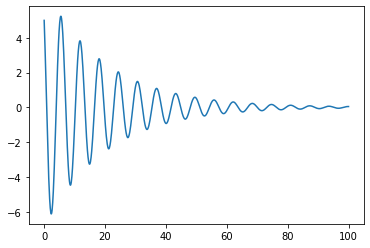

In [5]:
plt.plot(t_grid,free_trajectory[:,0])
plt.show()

# Oscillator with controller

In [6]:
# network which is used to learn trajectory
# written for a single initial value y0
class odeModel_oscillator_neural(tf.keras.Model):
    
    def __init__(self):
        super(odeModel_oscillator_neural, self).__init__()
        self.linear1 = keras.layers.Dense(50, activation="tanh")
        self.linear2 = keras.layers.Dense(1)
        self.A = tf.to_float([[0, 1],[-1, -0.1]])
        
    def call(self, inputs, **kwargs):
        t, y = inputs
        sys, con = tf.split(y,[2,1],1)
        
        dsys = tf.add(tf.matmul(sys, self.A), tf.concat([tf.to_float([[0.]]), con],1))
        dcon = self.linear1(sys)
        dcon = self.linear2(dcon)

        return tf.concat([dsys,dcon],1)    

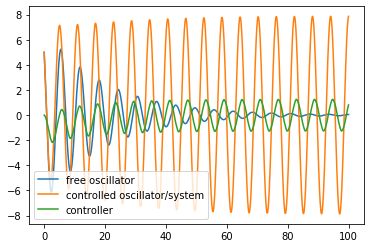

In [7]:
# initialise model

model=odeModel_oscillator_neural()
neural_ode = NeuralODE(model, t=t_grid)
neural_ode_test = NeuralODE(odeModel_oscillator_neural, t=t_grid)

# plot trajectory solved for random initial weights

time_steps = 1000
t_grid = np.linspace(0, 100, time_steps)
true_y0 = tf.to_float([[5., 5., 0.]])

neural_ode = NeuralODE(odeModel_oscillator_neural(), t=t_grid)
yN, trajectory = neural_ode.forward(true_y0, return_states="numpy")

trajectory = np.concatenate(trajectory)
# trajectory.shape

plt.plot(t_grid,free_trajectory[:,0],t_grid, trajectory[:,0], t_grid, trajectory[:,2])
plt.legend( ('free oscillator', 'controlled oscillator/system', 'controller'))
plt.show()

### Train

In [8]:
time_steps = 50
t_grid = np.linspace(0, 20, time_steps)
y0 = tf.to_float([[5., 5., 0.]])

batch_y0=tf.concat([y0,y0],0)

In [9]:
neural_ode = NeuralODE(odeModel_oscillator(), t=t_grid)
yN, free_trajectory = neural_ode.forward(y0_free, return_states="numpy")
free_trajectory = np.concatenate(free_trajectory)

In [10]:
optimizer = tf.train.MomentumOptimizer(learning_rate=1e-5, momentum=0.95)

In [11]:
# simple network which is used to learn trajectory
# written for a set of initial values y0
class odeModel_oscillator_neural_control(tf.keras.Model):  
    def __init__(self):
        super(odeModel_oscillator_neural_control, self).__init__()
        self.linear1 = keras.layers.Dense(50, activation="tanh")
        self.linear2 = keras.layers.Dense(1)
        self.A = tf.to_float([[0, 1],[-1, -0.1]])
        
    def call(self, inputs, **kwargs):
        t, y = inputs
        sys, con = tf.split(y,[2,1],1)
        
        dsys = tf.add(tf.matmul(sys, self.A), tf.concat([tf.to_float(np.zeros((y.shape.as_list()[0],1))), con],1))
        dcon = self.linear1(sys)
        dcon = self.linear2(dcon)
        
        return tf.concat([dsys,dcon],1)    
       
model=odeModel_oscillator_neural_control()
neural_ode = NeuralODE(model, t=t_grid)
neural_ode_test = NeuralODE(model, t=t_grid)

In [12]:
def compute_gradients_and_update_path(batch_y0):
    with tf.GradientTape() as g:
        
        pred_y, y_points = neural_ode.forward(batch_y0, return_states="tf") # solve ODE forward       
        pred_path = tf.stack(y_points)  # -> (batch_time, batch_size, 3) 
        loss = tf.reduce_mean(tf.math.square(pred_path), axis=1) # -> (batch_time, 2)   
        loss = tf.reduce_mean(loss, axis=0)
    
    gradients = g.gradient(loss, model.weights)  # tensorflow gradient computation
    optimizer.apply_gradients(zip(gradients, model.weights))
    return loss[0]

compute_gradients_and_update_path = tfe.defun(compute_gradients_and_update_path) # this makes the code faster

tf.Tensor(82.864494, shape=(), dtype=float32)


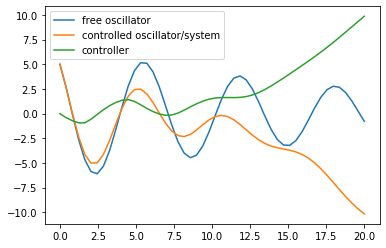

tf.Tensor(1.9003943, shape=(), dtype=float32)


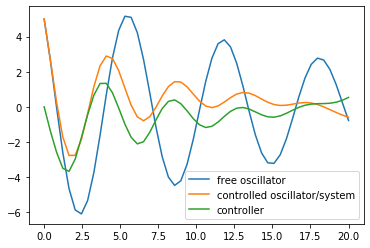

tf.Tensor(2.9876564, shape=(), dtype=float32)


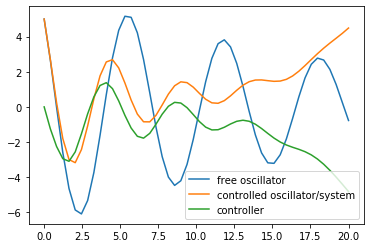

tf.Tensor(3.13225, shape=(), dtype=float32)


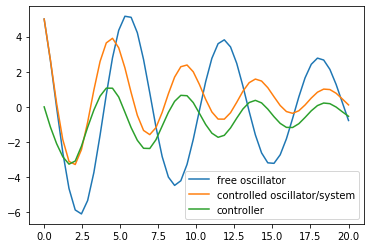

tf.Tensor(2.5847352, shape=(), dtype=float32)


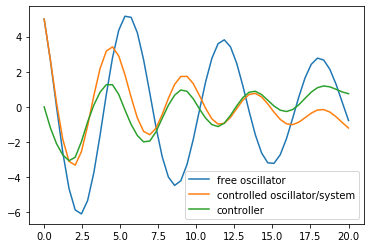

tf.Tensor(1.7880374, shape=(), dtype=float32)


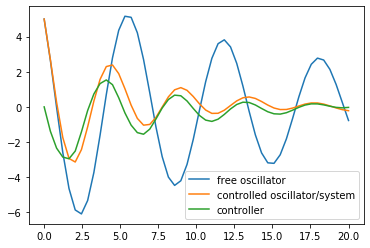

tf.Tensor(1.8508891, shape=(), dtype=float32)


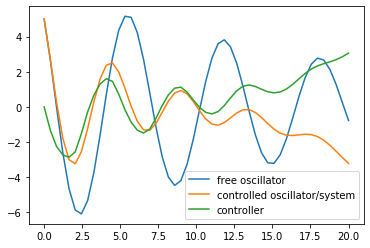

tf.Tensor(1.8735516, shape=(), dtype=float32)


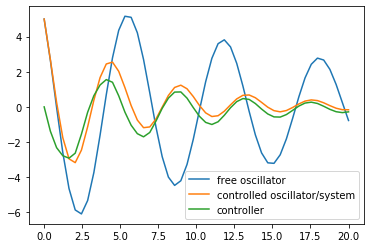

tf.Tensor(2.1402795, shape=(), dtype=float32)


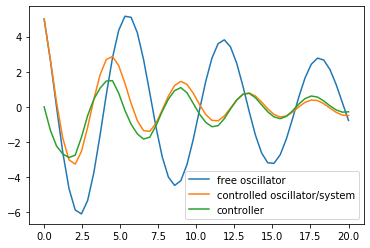

In [13]:
niters = 4000


loss_history = []
for step in range(niters+1):
    #batch_y0 = get_path_batch()
    batch_y0 = y0  # this should presumably be a list of random initial conditions 
    loss = compute_gradients_and_update_path(batch_y0)    
    loss_history.append(loss.numpy())
    
    if step % 500 == 0:        
        yN, states_history_model = neural_ode_test.forward(true_y0, return_states="numpy")  
        print(loss)
#         plot_spiral([true_y, np.concatenate(states_history_model)])        
        trajectory = np.concatenate(states_history_model)
        plt.plot(t_grid, free_trajectory[:,0], t_grid, trajectory[:,0], t_grid, trajectory[:,2])
        plt.legend( ('free oscillator', 'controlled oscillator/system', 'controller'))
        plt.show()

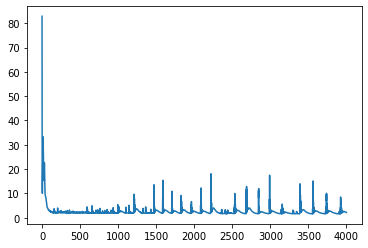

In [14]:
plt.plot(loss_history)